Deep Residual Network or Resnet was the state of the art framework in 2015. Mircosoft research team proposed it and with Resnet they won all mazor compitition of 2015 in all catagory. 
In theory, the deeper the network will be, it should perform better. But practically its not completely true. For deeper plain network after a few period loss start to increase due to [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). Here the idea of resnet saves us. In resnet we use some shortcut connections. These shortcut connection skips one or more layers. Most of the case these shortcuts are just identity mapping. 

![skip connection](http://puzzlemusa.com/wp-content/uploads/2018/04/resnet.png)

[image source](https://arxiv.org/pdf/1512.03385.pdf)

Here we are going to implement a 18 layer resnet in keras. First we will implement 2 shallow network(4 layer and then 6 layer).
Finally we will visualise our results.

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1.1 Import libraries

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.layers.merge import add
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import os

Using TensorFlow backend.


# 1.2 Initialize variables

In [0]:
batch_size = 128
num_classes = 10
epochs = 100

# 1.3 Collect and process data

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 19s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# 2.1 Define Model

In [0]:
def four_layer_model():
 
    model = Sequential()
  
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    
    model.add(Conv2D(32,(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
 
    return model

In [0]:
def six_layer_model():
  
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [0]:
def resnet():
  input = Input(shape=(32,32,3))
  
  conv1 = Conv2D(64, (7, 7), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1.e-4), input_shape=x_train.shape[1:])(input)
  norm1 = BatchNormalization(axis=3)(conv1)
  relu1 = (Activation('relu'))(norm1)
  pool1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(relu1)
  
  
  conv2 = Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(pool1)
  norm2 = BatchNormalization(axis=3)(conv2)
  relu2 = Activation('relu')(norm2)
  conv3 = Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu2)
  add1 = add([pool1, conv3])
  norm3 = BatchNormalization(axis=3)(add1)
  relu3 = Activation('relu')(norm3)
  conv4 = Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu3)
  norm4 = BatchNormalization(axis=3)(conv4)
  relu4 = Activation('relu')(norm4)
  conv5 = Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu4)
  add2 = add([add1, conv5])
  norm5 = BatchNormalization(axis=3)(add2)
  relu5 = Activation('relu')(norm5)
  
  conv6 = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu5)
  norm6 = BatchNormalization(axis=3)(conv6)
  relu6 = Activation('relu')(norm6)
  conv7 = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu6)
  conv71 = Conv2D(128, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(add2)
  add3 = add([conv7, conv71])
  norm7 = BatchNormalization(axis=3)(add3)
  relu7 = Activation('relu')(norm7)
  conv8 = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu7)
  norm8 = BatchNormalization(axis=3)(conv8)
  relu8 = Activation('relu')(norm8)
  conv9 = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu8)
  add4 = add([add3, conv9])
  norm9 = BatchNormalization(axis=3)(add4)
  relu9 = Activation('relu')(norm9)
  
  conv9 = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu9)
  norm9 = BatchNormalization(axis=3)(conv9)
  relu9 = Activation('relu')(norm9)
  conv10 = Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu9)
  conv101 = Conv2D(256, (2,2), strides=(2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(add4)
  add5 = add([conv10, conv101])
  norm10 = BatchNormalization(axis=3)(add5)
  relu10 = Activation('relu')(norm10)
  conv11 = Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu10)
  norm11 = BatchNormalization(axis=3)(conv11)
  relu11 = Activation('relu')(norm11)
  conv12 = Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu11)
  add6 = add([add5, conv12])
  norm12 = BatchNormalization(axis=3)(add6)
  relu12 = Activation('relu')(norm12)
  
  conv13 = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu12)
  norm13 = BatchNormalization(axis=3)(conv13)
  relu13 = Activation('relu')(norm13)
  conv14 = Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu13)
  conv141 = Conv2D(512, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(add6)
  add7 = add([conv14, conv141])
  norm14 = BatchNormalization(axis=3)(add7)
  relu14 = Activation('relu')(norm14)
  conv15 = Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu14)
  norm15 = BatchNormalization(axis=3)(conv15)
  relu15 = Activation('relu')(norm15)
  conv16 = Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(relu15)
  add8 = add([add7, conv16])
  norm16 = BatchNormalization(axis=3)(add8)
  relu16 = Activation('relu')(norm16)
  
  pool2 = AveragePooling2D(pool_size=(1,1), strides=(1,1))(relu16)
  flaten = Flatten()(pool2)
  dense = Dense(num_classes, kernel_initializer='he_normal', activation='softmax')(flaten)
  
  model = Model(input, dense)
  
  return model

# 2.2 Choosing optimization

In [0]:
opt = Adam(lr = 0.0001, decay=1e-6) 
model4 = four_layer_model()
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
opt = Adam(lr = 0.0001, decay=1e-6)
model6 = six_layer_model()
model6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')
resnet_model = resnet()
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# 2.3 Training

In [0]:
model4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), shuffle=True)

In [0]:
model6 = model6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), shuffle=True)

In [0]:
resnet_model = resnet_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=[lr_reducer, early_stopper, csv_logger])

# 3.1 Visualization

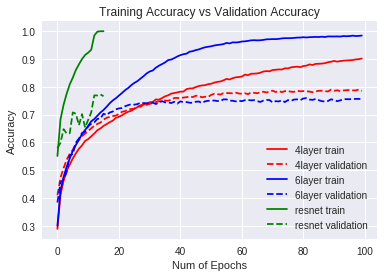

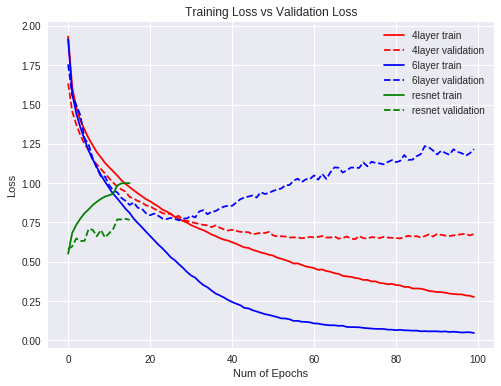

In [14]:
plt.figure(0)
plt.plot(model4.history['acc'],'r')
plt.plot(model4.history['val_acc'],'r--')
plt.plot(model6.history['acc'],'b')
plt.plot(model6.history['val_acc'],'b--')
plt.plot(resnet_model.history['acc'],'g')
plt.plot(resnet_model.history['val_acc'],'g--')
plt.xticks(np.arange(0, 101, 20))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['4layer train','4layer validation', '6layer train', '6layer validation', 'resnet train', 'resnet validation'])
 
 
plt.figure(1)
plt.plot(model4.history['loss'],'r')
plt.plot(model4.history['val_loss'],'r--')
plt.plot(model6.history['loss'],'b')
plt.plot(model6.history['val_loss'],'b--')
plt.plot(resnet_model.history['acc'],'g')
plt.plot(resnet_model.history['val_acc'],'g--')
plt.xticks(np.arange(0, 101, 20))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['4layer train','4layer validation', '6layer train', '6layer validation', 'resnet train', 'resnet validation'])
 
 
plt.show()